# Figure 1

In [1]:
import os
import numpy
import matplotlib
from matplotlib import pyplot
%matplotlib notebook

import pykerr

from pycbc.inference import io
from pycbc import conversions
import scatter_histograms
from matplotlib import gridspec
from pycbc import distributions

In [2]:
dirname = '../posteriors/agnostic/'
ftmplt = 'AGNOSTIC-{}MS.hdf'
pltdir = './'

In [56]:
def make_spectra_plot(fn, use_kombine=False, logscale=False, modes=None,
                      plotbins=None, hpdminor=True, annotate_time=None,
                      refl=2, refm=2):
    fp = io.loadfile(fn, 'r')

    # get the bins
    cp = fp.read_config_file()
    vparams = cp.options('variable_params')
    if plotbins is None:
        plotbins = ['c', 'a', 'b']
    bins = {}
    mins = {}
    maxs = {}
    # original parameter names and priors used '220' for range A,
    # '310' for range B, and '110' for range C, as the ringdown code
    # expects names to follow an iii format. These were renamed when
    # the posterior file was extracted, but since the prior parameters
    # have the original names, we need to map them
    binmap = {'a': '220', 'b': '310', 'c': '110'}
    
    for fbin in plotbins:
        minf = float(cp.get('prior-f_{}'.format(binmap[fbin]),
                            'min-f_{}'.format(binmap[fbin])))
        maxf = float(cp.get('prior-f_{}'.format(binmap[fbin]),
                            'max-f_{}'.format(binmap[fbin])))
        bins[fbin] = (minf, maxf)
        mins[fbin] = minf
        maxs[fbin] = maxf
    
    samples = fp.read_samples(fp['samples'].keys())

    # prior samples
    prior_norms = {}
    cp = fp.read_config_file()
    dists = distributions.read_distributions_from_config(cp)
    const = distributions.read_constraints_from_config(cp)
    prior = distributions.JointDistribution(cp.options('variable_params'), *dists, *const)
    for p in prior.distributions:
        if p.params[0].startswith('f_'):
            prior_norms[p.params[0]] = p.norm

    fp.close()

    # estimate the mass and spin from the A bin assuming it is the refl, refm mode (default 2,2,0)
    mass_est = samples['final_mass_from_f0_tau(f_a, tau_a, {}, {})'.format(refl, refm)]
    spin_est = samples['final_spin_from_f0_tau(f_a, tau_a, {}, {})'.format(refl, refm)]

    # exclude naked singularities and negative mass
    mask = numpy.isfinite(mass_est) & numpy.isfinite(spin_est)
    mask &= mass_est > 0
    mask &=  abs(spin_est) < 1

    mass_est = mass_est[mask]
    spin_est = spin_est[mask]

    # now get expected distributions for the other modes
    if modes is None:
        modes = [(3, 3, 0), (4, 4, 0), (5, 5, 0)]

    mode_samples = {}
    for l, m, n in modes:
        freqs = pykerr.qnmfreq(mass_est, spin_est, l, m, n)
        taus = pykerr.qnmtau(mass_est, spin_est, l, m, n)
        # to get the contours to plot on the axes we have to name
        # the mode samples the same as the parameters plotted in
        # the axis
        if (l, m, n) == (2, 1, 0):
            fa = io.FieldArray.from_kwargs(f_c=freqs, tau_c=taus,
                                           f_a=freqs, tau_a=taus)
        else:
            fa = io.FieldArray.from_kwargs(f_b=freqs, tau_b=taus)
        mode_samples[l, m, n] = fa

    colors = {(3, 3, 0): (0, 0, 1),  # blue
              (3, 2, 0): 'yellow',
              (4, 4, 0): (0, 1, 0),  # green
              (5, 5, 0): (1, 0, 0),  # red
              (2, 1, 0): 'magenta',
              (2, 2, 0): 'magenta'
             }

    # construct grid
    labels = {}
    if logscale:
        # set the relative proportions of the plots to the same as
        # the log of the frequency bins
        fbins = numpy.array(list(bins.values()))
        fbins.sort(axis=0)
        fbins = numpy.array(list(bins.values()))
        width_ratios = numpy.diff(numpy.log10(fbins), axis=1).flatten()
        wr = dict(zip(plotbins, width_ratios))
    else:
        width_ratios = (1,2)
    if len(plotbins) == 3:
        fsize = (18, 6)
    else:
        fsize = (14, 6)
    fig = pyplot.figure(figsize=fsize)
    gs = fig.add_gridspec(2, len(bins.keys()), width_ratios=width_ratios,
                           height_ratios=(1,2), wspace=0.01, hspace=0.03)

    axis_dict = {}
    params = []
    for ii, md in enumerate(plotbins):
        fparam = 'f_{}'.format(md)
        tparam = 'tau_{}'.format(md)
        labels[fparam] = r'$f_{%s}$' %(md)
        labels[tparam] = r'$\tau_{%s}$' %(md)
        # 1D marginal
        ax = pyplot.subplot(gs[0, ii])
        axis_dict[fparam, fparam] = (ax, 0, ii)
        # 2D marginal
        ax = pyplot.subplot(gs[1, ii])
        if logscale:
            ax.semilogx()
        # force ticks to be scalar
        ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
        # make background black
        ax.set_facecolor('k')
        axis_dict[fparam, tparam] = (ax, 1, ii)
        params.extend([tparam, fparam])
        if ii == 0:
            ax.set_ylabel(r'damping time (s)', fontsize=16)
        # put ticks on right side
        if ii != 0:
            ax.set_yticks([])
    # add a common x label
    fig.text(0.5, 0.035, 'frequency (Hz)', ha='center', fontsize=16)
    
    for md in plotbins:
        px = 'f_{}'.format(md)
        py = 'tau_{}'.format(md)
        ax = axis_dict[px, py][0]
        # annotate
        ax.annotate('Range {}'.format(md.upper()), (1-0.02*width_ratios.max()/wr[md], 0.9),
                    xycoords='axes fraction', color='white',
                    ha='right',
                    fontsize=18, zorder=10)
        # limit the number of samples used to build the kde for speed
        kdeargs = {'max_samples': 10000}
        if True:
            scatter_histograms.create_density_plot(px, py, samples,
                                                   plot_density=True, cmap='inferno',
                                                   plot_contours=True, percentiles=[50, 90],
                                                   contour_color='white',
                                                   contour_linestyles=['dashed', 'dotted'],
                                                   label_contours=False,
                                                   use_kombine=use_kombine,
                                                   kdeargs=kdeargs,
                                                   fig=fig, ax=ax)
        # 1d marginal
        ax = axis_dict[px, px][0]
        # divide the parameter space up equally
        fmin = 15.
        fmax = 256.
        #fmin, fmax = bins[md]
        if logscale:
            bx = numpy.geomspace(fmin, fmax, 400)
        else:
            bx = numpy.linspace(fmin, fmax, 400)
        if hpdminor or md == '220':
            hpd = 90
            fillcolor='gray'
        else:
            hpd = None
            fillcolor='none'
        scatter_histograms.create_marginalized_hist(ax, samples[px], '', hpd=hpd,
                                                    bins=bx,
                                                    title=False,
                                                    percentiles=[],
                                                    linecolor='black',
                                                    fillcolor=fillcolor,
                                                    logscale=logscale
                                                   )
        # plot the prior
        ax.axhline(prior_norms['f_'+binmap[md]], c='black', ls=':')


    # make range c have the same 1D marginal y limits as range A so we don't get a massive-looking prior
    if 'c' in plotbins:
        axa = axis_dict['f_a', 'f_a'][0]
        axc = axis_dict['f_c', 'f_c'][0]
        axc.set_ylim(*axa.get_ylim())

    
    # add the expected area for the modes
    ymaxs = {md: None for md in plotbins}
    for mode in modes:
        if mode == (2, 1, 0):
            mds = ['c', 'a']
        else:
            mds = ['b']
        for md in mds:
            px = 'f_{}'.format(md)
            py = 'tau_{}'.format(md)
            ax1d = axis_dict[px, px][0]
            ax2d = axis_dict[px, py][0]
            if ymaxs[md] is None:
                ymaxs[md] = ax1d.get_ylim()[1]
            ymax = ymaxs[md]
            scatter_histograms.create_density_plot(px, py, mode_samples[mode],
                                                   plot_density=False, plot_contours=True,
                                                   percentiles=[90],
                                                   contour_color=colors[mode],
                                                   contour_linestyles=['dashed'],
                                                   label_contours=False,
                                                   use_kombine=use_kombine, kdeargs=kdeargs,
                                                   fig=fig, ax=ax2d)
            # shade the marginal
            x = numpy.percentile(mode_samples[mode][px], [5, 95])
            ax1d.fill_between(x, 0, ymax, color=colors[mode], alpha=0.5,
                              zorder=-1,
                              label='Expected {}'.format(''.join(map(str, mode))))
            ax1d.set_xlim(mins[md], maxs[md])
            ax1d.set_ylim(ymax=ymax)
            if md == 'b':
                ax1d.legend(loc='upper right', fontsize=14)
            elif md == 'c':
                ax1d.legend(loc='upper left', fontsize=14)

    # set limits on the 2D plots
    tmin = 0.001
    tmax = 0.1
    for md in plotbins:
        px = 'f_{}'.format(md)
        py = 'tau_{}'.format(md)
        ax = axis_dict[px, py][0]
        ax.set_ylim(tmin, tmax)
        ax.set_xlim(mins[md], maxs[md])
        ax = axis_dict[px, px][0]
        ax.set_xlim(mins[md], maxs[md])
            
    # remove the left tick label on the right tau f plot
    for md in plotbins[1:]:
        ax2d = axis_dict['f_{}'.format(md), 'tau_{}'.format(md)][0]
        ticks = ax2d.xaxis.get_minor_ticks()
        for ii, t in enumerate(ax2d.get_xticks(minor=True)):
            if t == bins[md][0]:
                ticks[ii].label1.set_visible(False)

    # force 1d tick labels off
    for md in plotbins:
        ax = axis_dict['f_{}'.format(md), 'f_{}'.format(md)][0]
        ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    if annotate_time is not None:
        fig.text(0.5, 0.9, r'$t_{{\rm ref}} + {}\,$ms'.format(int(annotate_time)),
                 ha='center', fontsize=16)
    return fig, axis_dict, samples

<IPython.core.display.Javascript object>


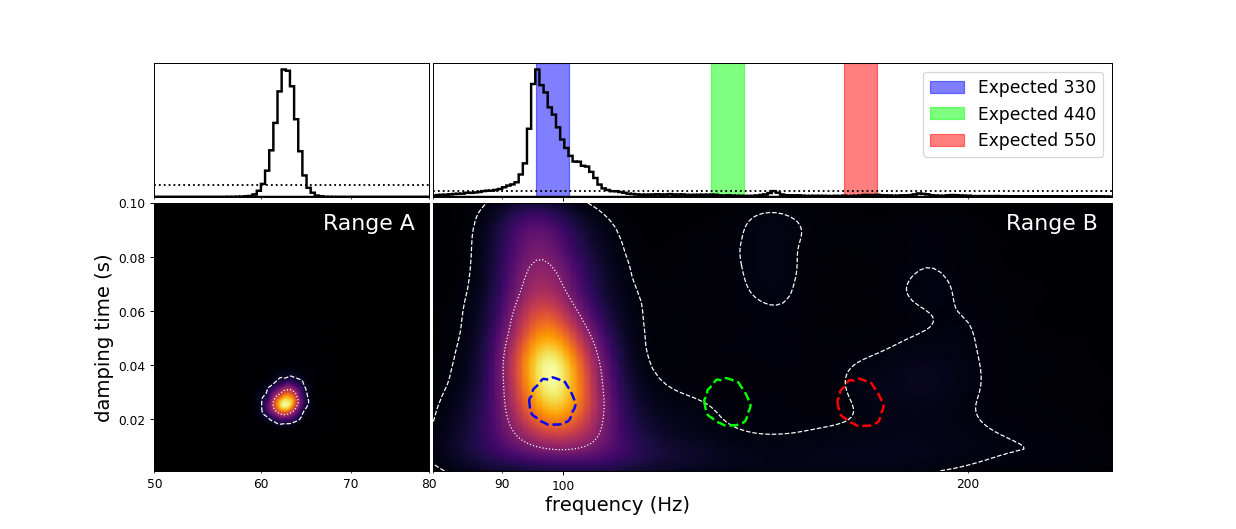

In [59]:
toffset = '06'
fn = dirname + ftmplt.format(toffset)
fig, axis_dict, samples = make_spectra_plot(fn, logscale=True, hpdminor=False,
                                            plotbins=['a', 'b'], modes=None)
fig.savefig('Figure1.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


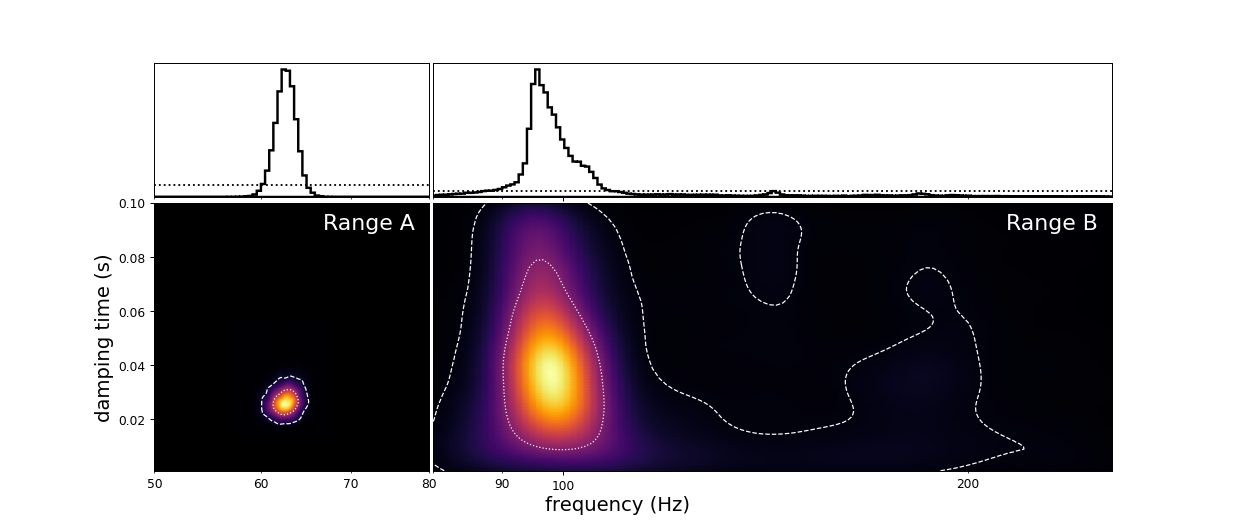

In [49]:
toffset = '06'
fn = dirname + ftmplt.format(toffset)
fig, axis_dict, samples = make_spectra_plot(fn, logscale=True, hpdminor=False,
                                            plotbins=['a', 'b'], modes=[])
fig.savefig('Figure1-noexpected.png')

## Figure S4

<IPython.core.display.Javascript object>


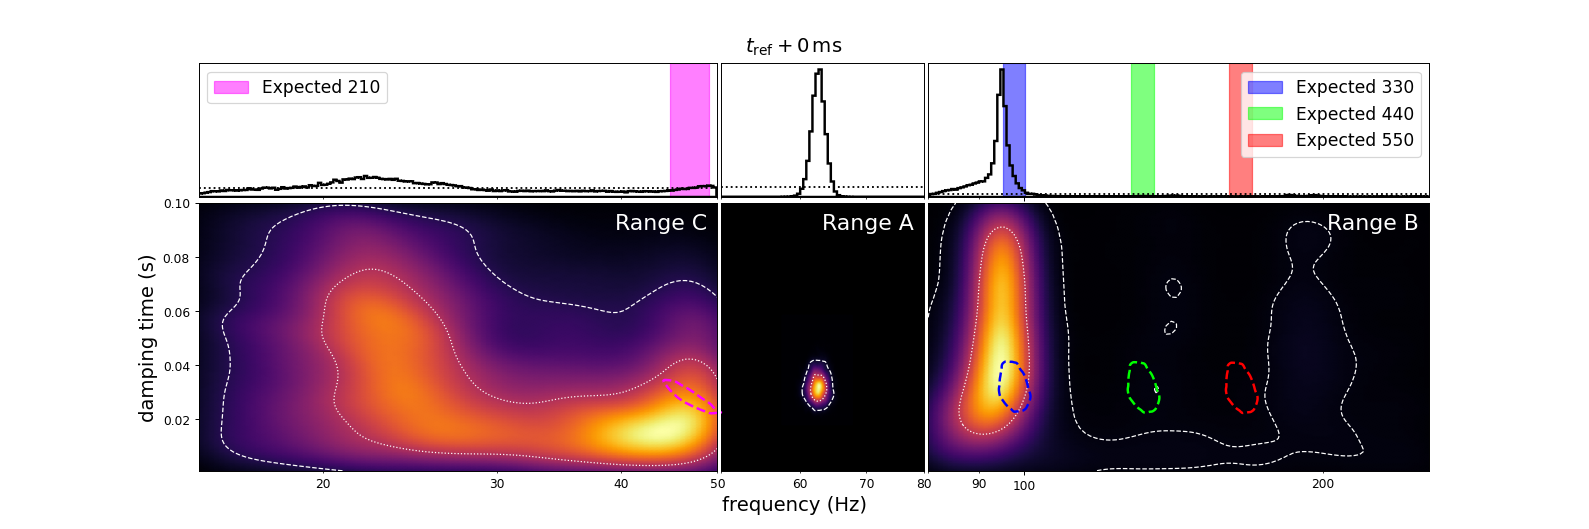

<IPython.core.display.Javascript object>


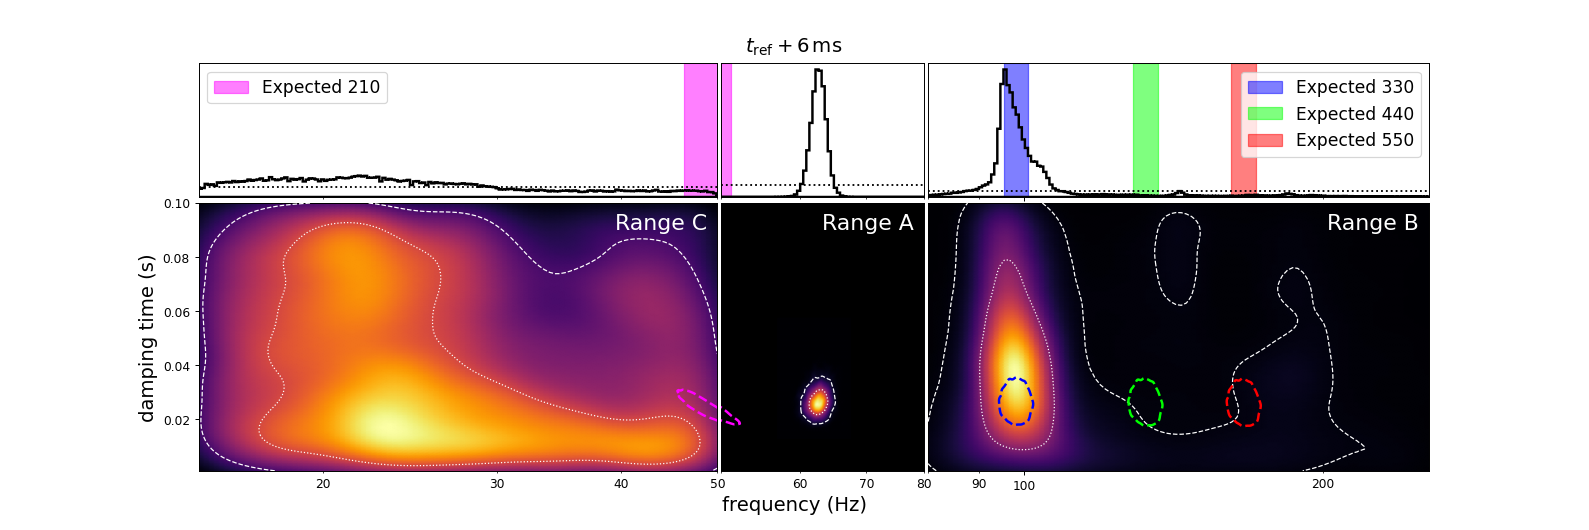

<IPython.core.display.Javascript object>


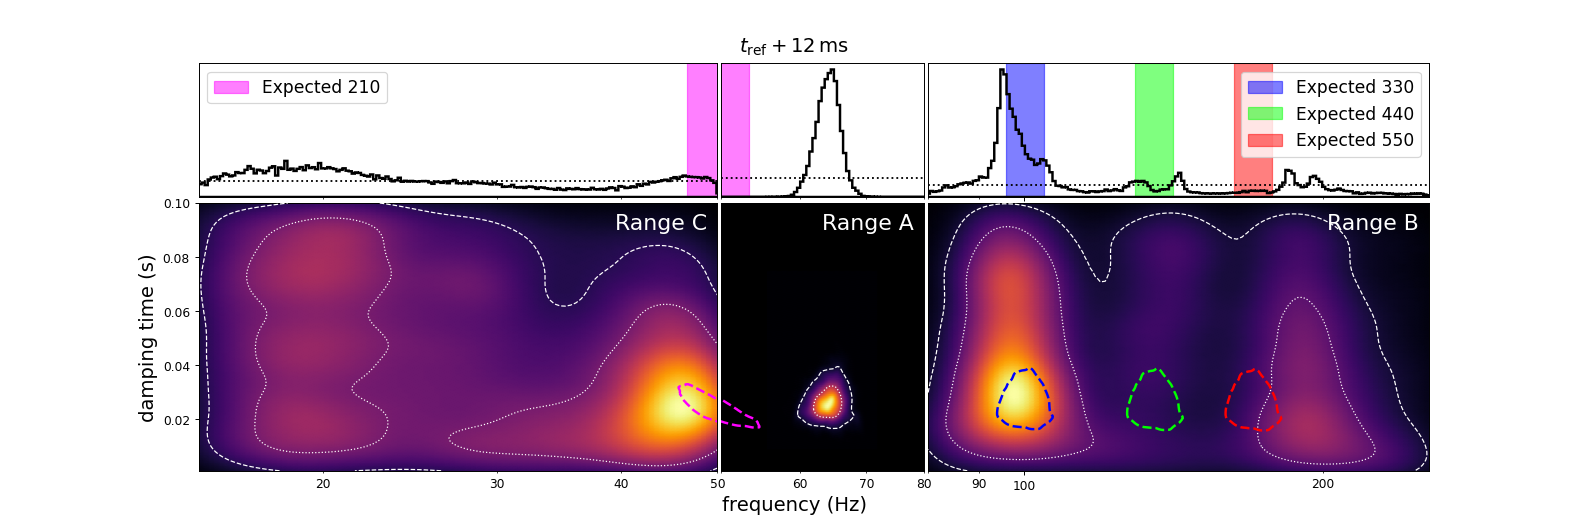

<IPython.core.display.Javascript object>


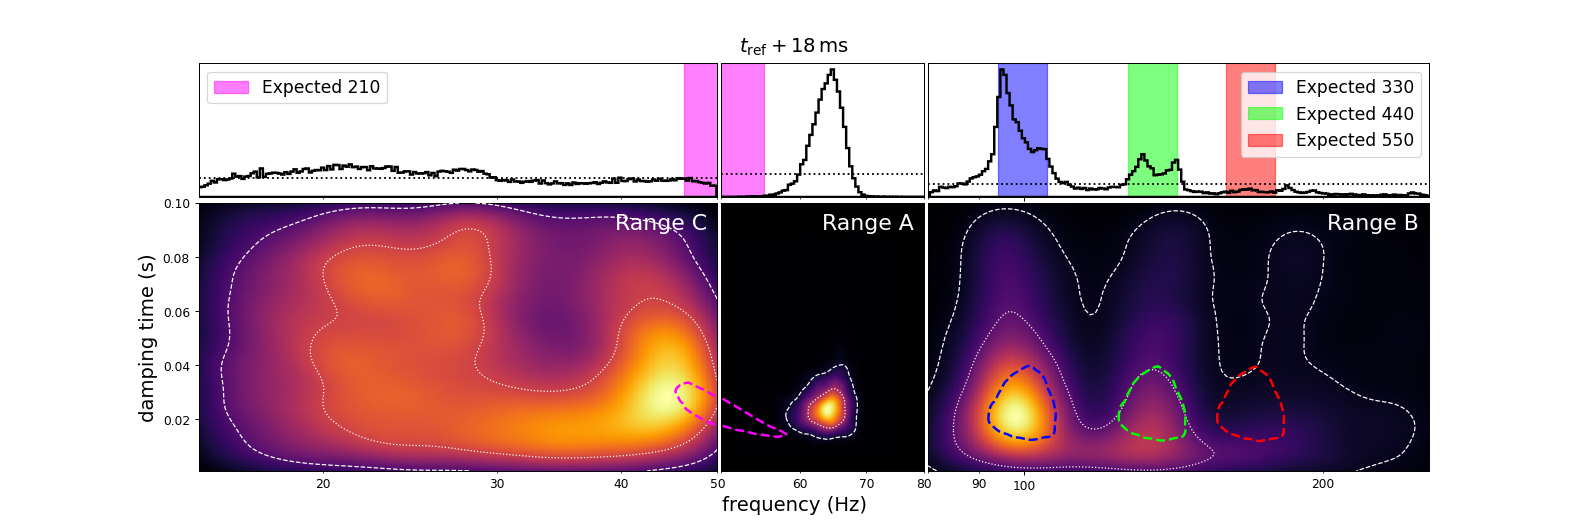

<IPython.core.display.Javascript object>


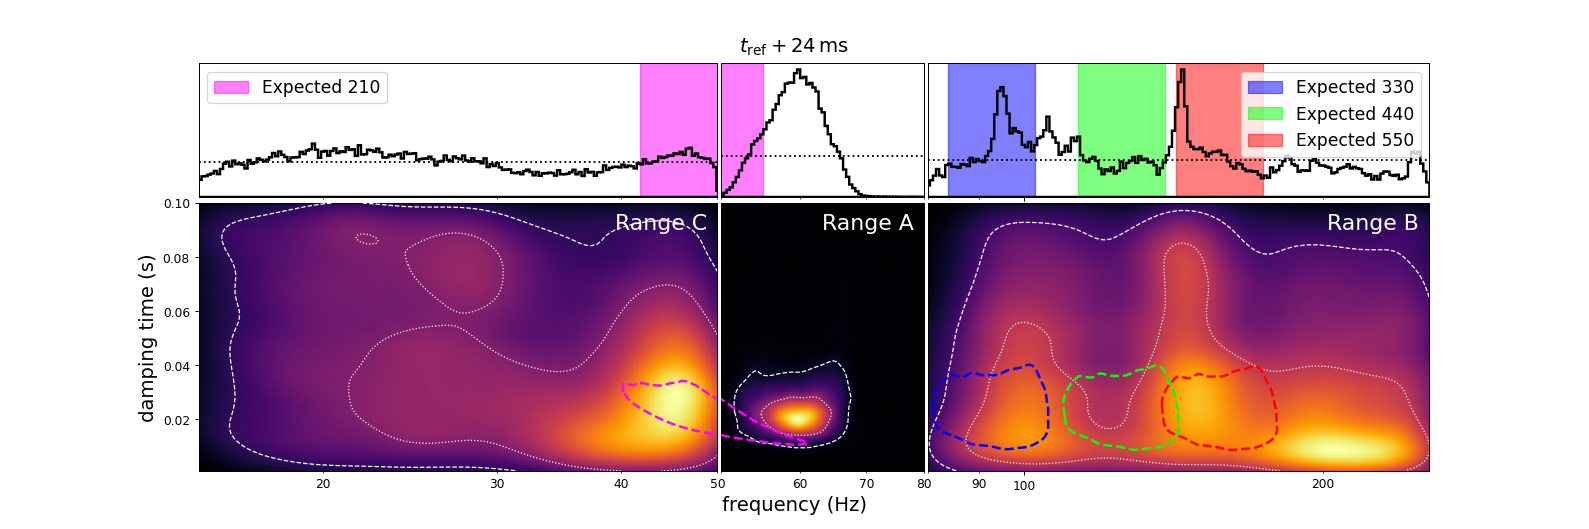

In [58]:
pltname = pltdir + 'agnostic_density_plot-{}MS.png'
for toffset in ['00', '06', '12', '18', '24']:
    fn = dirname + ftmplt.format('{}'.format(toffset))
    fig, axis_dict, samples = make_spectra_plot(fn, logscale=True,
                                                annotate_time=int(toffset),
                                                plotbins=['c', 'a', 'b'], hpdminor=False,
                                                modes=[(2,1,0), (3,3,0), (4,4,0), (5,5,0)])
    fig.savefig(pltname.format(toffset))